# Mean Reversion and the Limits of Short-Horizon Trading

This notebook evaluates a simple mean reversion strategy based on price deviation and examines its robustness under transaction costs and parameter sensitivity.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from core.signals import z_score_signal
from core.backtest import mean_reversion_backtest
from core.utils import *
from core.metrics import *

In [2]:
TICKER = "SPY"
START = "2015-01-01"
END = None
HORIZON = 1

In [3]:
data = fetch_data([TICKER], start=START, end=END)
df = data[TICKER]
df.columns = df.columns.get_level_values(0)
print(df.head())

c:\Users\palas\Documents\Books\alpha\core\utils.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, period=period, interval=interval, progress=False)


Price            Close        High         Low        Open     Volume  \
Date                                                                    
2015-01-02  170.589630  171.793724  169.551627  171.378523  121465900   
2015-01-05  167.508835  169.709397  167.201590  169.543319  169632600   
2015-01-06  165.931076  168.339239  165.133884  167.816081  209151400   
2015-01-07  167.998703  168.339171  166.811234  167.259645  125346700   
2015-01-08  170.979889  171.195802  169.393830  169.410429  147217800   

Price            close  
Date                    
2015-01-02  170.589630  
2015-01-05  167.508835  
2015-01-06  165.931076  
2015-01-07  167.998703  
2015-01-08  170.979889  


## Signal Construction

We construct a mean reversion signal using the Z-score of price relative to a rolling mean and volatility estimate.

In [4]:
LOOKBACK = 40
ENTRY_Z = 2.0
EXIT_Z = 0.0
price = df['Close']

z_score = z_score_signal(price, lookback=LOOKBACK)
z_score = z_score.loc[price.index].dropna()
price = price.loc[z_score.index].dropna()

## Backtest Without Transaction Costs

We first evaluate the strategy in an idealized setting without trading frictions.

In [5]:
equity, trades, position = mean_reversion_backtest(
    price, 
    z_score, 
    entry_z=ENTRY_Z, 
    exit_z=EXIT_Z
)

## Backtest With Transaction Costs

We repeat the experiment with modest transaction costs applied at entry and end.

In [6]:
COST_PER_TRADE = 0.05

equity_tc, trades_tc, position_tc = mean_reversion_backtest(
    price, 
    z_score, 
    entry_z=ENTRY_Z, 
    exit_z=EXIT_Z, 
    cost_per_trade=COST_PER_TRADE
)

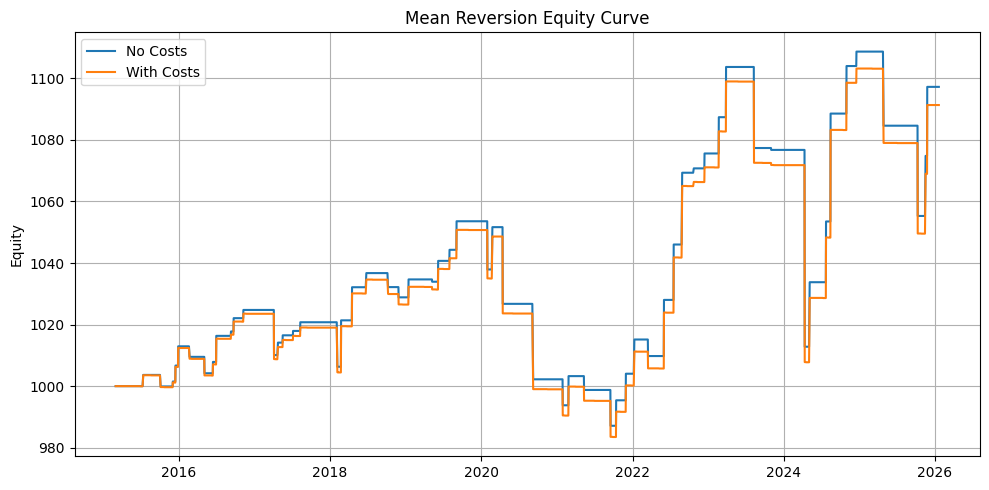

In [7]:
plot_equity(
    {
        "No Costs": equity, 
        "With Costs": equity_tc
    },
    title="Mean Reversion Equity Curve",
    fname="../results/mean_rev_plot.png"
)

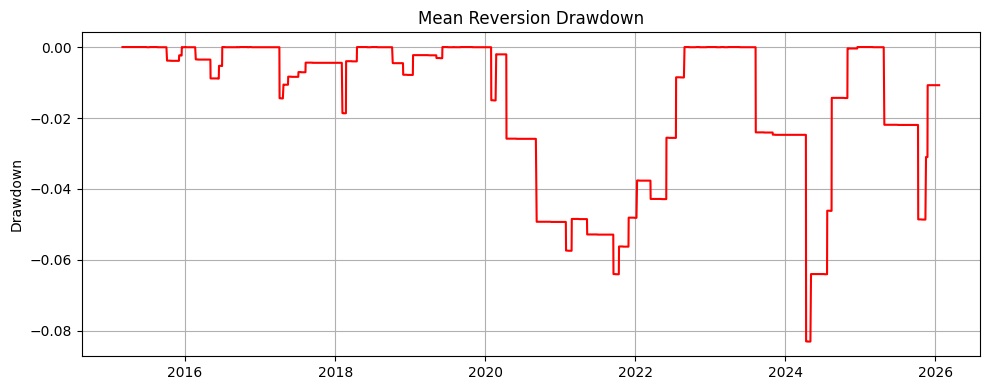

In [8]:
plot_drawdowns(equity_tc, title="Mean Reversion Drawdown", fname="../results/drawdowns.png")

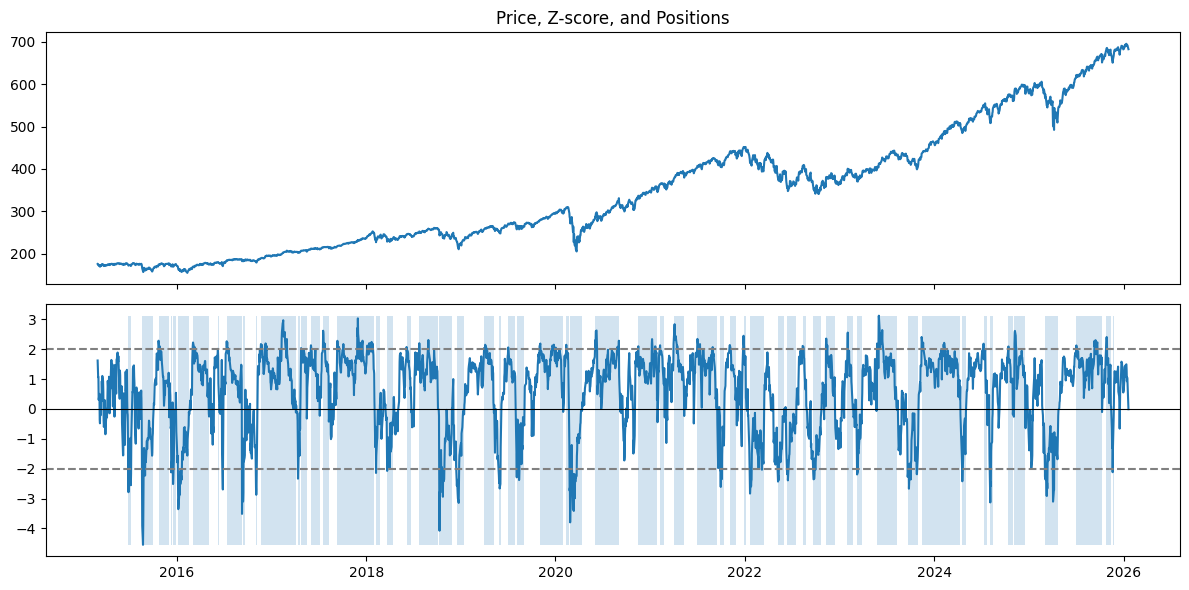

In [9]:
plot_price_z_position(
    price, 
    z_score, 
    position_tc, 
    entry_z=ENTRY_Z, 
    title="Price, Z-score, and Positions",
    fname="../results/price_z_pos.png"
)

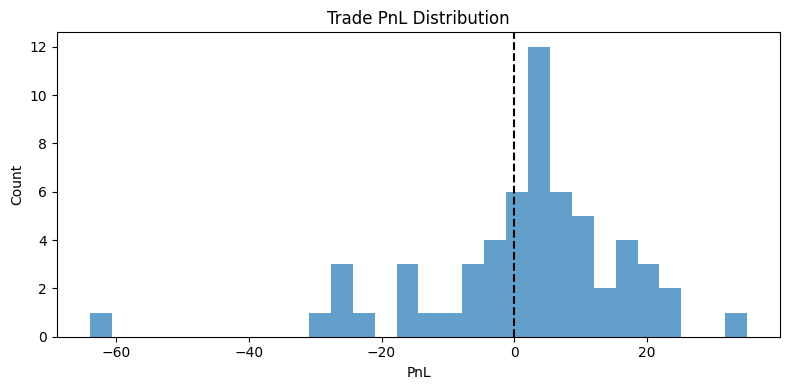

In [10]:
plot_trade_pnl(trades_tc, title="Trade PnL Distribution", fname="../results/trade_pnl.png")

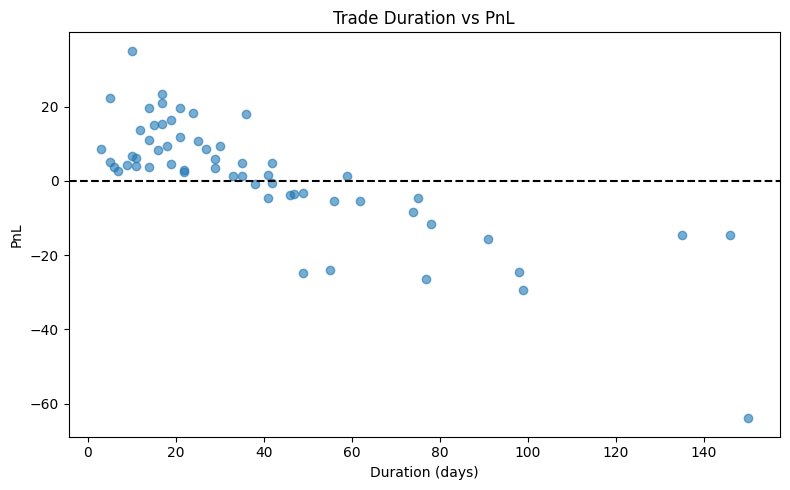

In [11]:
plot_duration_vs_pnl(trades_tc, title="Trade Duration vs PnL", fname="../results/trade_duration.png")

In [13]:
strategy_summary(equity_tc, trades_tc, tname="../results/mean_rev_strat_sum.md")

,Total Return,Sharpe,Max Drawdown,Win Rate,Avg Trade PnL,Num Trades
0,0.091324,0.248637,-0.083012,0.661017,1.647857,59


In [14]:
cost_impact_table(equity, equity_tc, tname="../results/cost_impact.md")

,Scenario,Total Return
0,No Costs,0.097224
1,With Costs,0.091324


## Sensitivity to Entry Threshold

We test sensitivity by varying the entry threshold while holding all other parameters fixed.

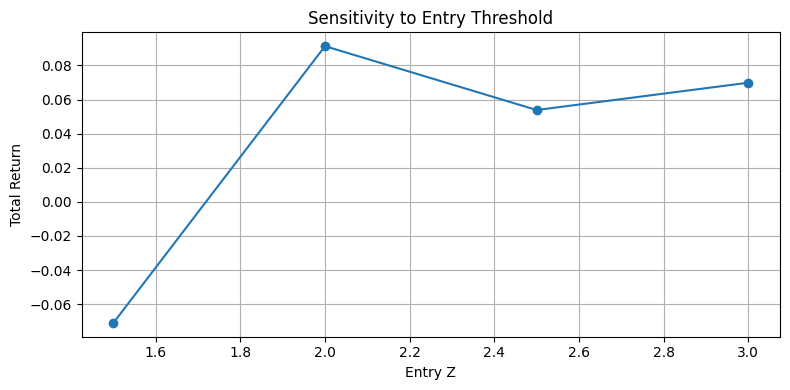

In [15]:
thresholds = [1.5, 2.0, 2.5, 3.0]
returns = []

for th in thresholds:
    eq, _, _ = mean_reversion_backtest(
        price = price,
        z_score = z_score,
        entry_z=th,
        exit_z=EXIT_Z,
        cost_per_trade=COST_PER_TRADE
    )
    returns.append(eq.iloc[-1] / eq.iloc[0] - 1)

plot_sensitivity(
    thresholds,
    returns,
    xlabel="Entry Z",
    ylabel="Total Return",
    title="Sensitivity to Entry Threshold", 
    fname="../results/sensitivity_entry_threshold.png"
)

## Interpretation

The mean reversion strategy exhibits occasional profitability in the absence of transaction costs, but performance deteriorates rapidly once modest frictions are introduced.

Drawdowns are large relative to cumulative returns, and results are sensitive to parameter choices and market regimes. These finidings suggest that short-horizon mean reversion is structurally fragile rather than robustly exploitable.